# Testing LR and GWR on the existing data

## Import packages

In [15]:
import pandas as pd
import libpysal
import matplotlib.pyplot as plt
import mgwr
import numpy as np
import pysal
from pysal import model
import geopandas as gpd

## Import shapefile

Download and read MSOA shapefile data.

If the MSOA shapefile is not there, run the next cell to download it.

In [16]:
# note that this dataset contains all 7201 MSOAs in England. This dataset is used as it contains the high resolution boundary and neighbour topology of MSOAs 
# url = 'https://github.com/jreades/fsds/raw/master/data/src/Middle_Layer_Super_Output_Areas__December_2011__EW_BGC_V2-shp.zip'

#! wget $url

In [17]:
# path_data_folder = '../Data'
gdf = gpd.read_file(f"../Data/Middle_Layer_Super_Output_Areas__December_2011__EW_BGC_V2-shp.zip!Middle_Layer_Super_Output_Areas__December_2011__EW_BGC_V2.shp")
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 7201 entries, 0 to 7200
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    7201 non-null   int64   
 1   MSOA11CD    7201 non-null   object  
 2   MSOA11NM    7201 non-null   object  
 3   MSOA11NMW   7201 non-null   object  
 4   BNG_E       7201 non-null   int64   
 5   BNG_N       7201 non-null   int64   
 6   LONG        7201 non-null   float64 
 7   LAT         7201 non-null   float64 
 8   Shape__Are  7201 non-null   float64 
 9   Shape__Len  7201 non-null   float64 
 10  geometry    7201 non-null   geometry
dtypes: float64(4), geometry(1), int64(3), object(3)
memory usage: 619.0+ KB


In [18]:
gdf.crs

<Projected CRS: EPSG:27700>
Name: OSGB 1936 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: OSGB 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

## Import uptake data

In [19]:
# import df_uptake data
df_uptake = pd.read_csv("../data/vaccine_uptake_socioeco.csv")

In [20]:
df_uptake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6787 entries, 0 to 6786
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      6787 non-null   int64  
 1   MSOA                            6787 non-null   object 
 2   18over1st_dose                  6787 non-null   int64  
 3   18over2nd_dose                  6787 non-null   int64  
 4   pop0_17                         6787 non-null   int64  
 5   pop18over                       6787 non-null   int64  
 6   vaccination_percentage_1stdose  6787 non-null   float64
 7   vaccination_percentage_2nddose  6787 non-null   float64
 8   vaccination_percentage_total    6787 non-null   float64
 9   IMD19 SCORE                     6787 non-null   float64
 10  msoa_imd_decile                 6787 non-null   int64  
 11  pct_White                       6787 non-null   float64
 12  pct_Mixed                       67

In [21]:
# one-hot encoding of MSOADECILE
df_uptake = pd.get_dummies(df_uptake, prefix=['msoa_imd_decile'], columns=['msoa_imd_decile'])

In [22]:
df_uptake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6787 entries, 0 to 6786
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      6787 non-null   int64  
 1   MSOA                            6787 non-null   object 
 2   18over1st_dose                  6787 non-null   int64  
 3   18over2nd_dose                  6787 non-null   int64  
 4   pop0_17                         6787 non-null   int64  
 5   pop18over                       6787 non-null   int64  
 6   vaccination_percentage_1stdose  6787 non-null   float64
 7   vaccination_percentage_2nddose  6787 non-null   float64
 8   vaccination_percentage_total    6787 non-null   float64
 9   IMD19 SCORE                     6787 non-null   float64
 10  pct_White                       6787 non-null   float64
 11  pct_Mixed                       6787 non-null   float64
 12  pct_Asian                       67

In [23]:
df_uptake['vaccination_percentage_2nddose'].head()

0    0.999152
1    0.961992
2    0.979597
3    0.910034
4    0.910515
Name: vaccination_percentage_2nddose, dtype: float64

In [24]:
df_uptake.columns

Index(['Unnamed: 0', 'MSOA', '18over1st_dose', '18over2nd_dose', 'pop0_17',
       'pop18over', 'vaccination_percentage_1stdose',
       'vaccination_percentage_2nddose', 'vaccination_percentage_total',
       'IMD19 SCORE', 'pct_White', 'pct_Mixed', 'pct_Asian', 'pct_black',
       'pct_other', 'pct_hh_car', 'MSOA11CD', 'income_score', 'employ_score',
       'edu_score', 'health_score', 'crime_score', 'housing_score',
       'livEnv_score', 'msoa_imd_decile_1', 'msoa_imd_decile_2',
       'msoa_imd_decile_3', 'msoa_imd_decile_4', 'msoa_imd_decile_5',
       'msoa_imd_decile_6', 'msoa_imd_decile_7', 'msoa_imd_decile_8',
       'msoa_imd_decile_9', 'msoa_imd_decile_10'],
      dtype='object')

<AxesSubplot:>

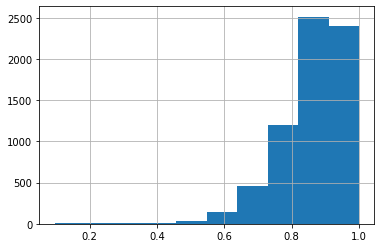

In [25]:
df_uptake.vaccination_percentage_2nddose.hist()

## Creating queen's weight matrix

In [26]:
# gdf: only keep the MSOAs in the df_uptake
gdf_england = gdf.loc[gdf.MSOA11CD.isin(df_uptake.MSOA)]
# Calculating neighbours based on the Queen's contiguity
wq = libpysal.weights.Queen.from_dataframe(gdf_england)

/home/huanfa/miniconda3/envs/sds2021/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
  warnings.warn(message)


<AxesSubplot:>

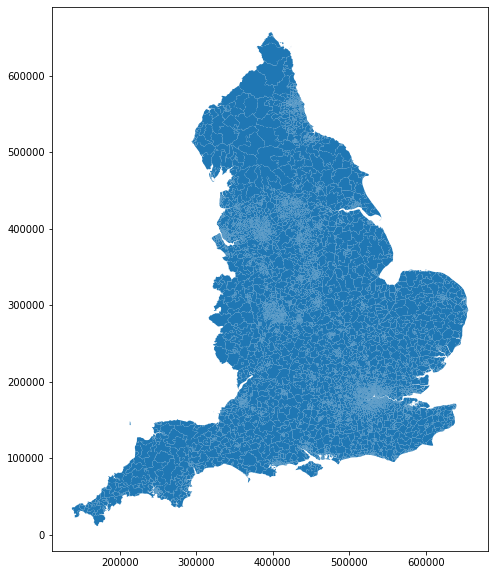

In [27]:
# Now we can visualise the weights in the map
f, ax = plt.subplots(1,1, figsize=(10,10))
gdf_england.plot(ax=ax)
# wq.plot(gdf_england_no_London, ax=ax)

## OLS using mgwr package

In [28]:
# First, you need to prepare the dataset so it can be processed in pysal
uptake_rate = df_uptake['vaccination_percentage_2nddose']
# OLS class requires data to be passed as numpy array
y = np.array(uptake_rate)
# PySAL requires your dependent variable to be nx1 numpy array
y.shape = (len(uptake_rate),1)

In [44]:
# Now prepare your independent variables
X = []
# list_x_var = ['MSOADECILE_2' , 'MSOADECILE_3' , 'MSOADECILE_4' , 'MSOADECILE_5' , 'MSOADECILE_6' , 'MSOADECILE_7' , 'MSOADECILE_8' , 'MSOADECILE_9' , 'MSOADECILE_10', \
#  'E2sfca_10'  , 'Per_cent_of_households_with_at_least_one_car_or_van' , 'Mixed%' , 'Asian%' , 'Black%' , 'Other%']
# list_x_var = ['income_score' , 'employ_score' , 'edu_score' , 'health_score' , 'crime_score' , 'housing_score' , 'livEnv_score' ,
#  'pct_hh_car' , 'pct_Mixed' , 'pct_Asian' , 'pct_black' , 'pct_other']

list_x_var = ['employ_score' , 'edu_score' , 'health_score' , 'crime_score' , 'housing_score' , 'livEnv_score' ,
 'pct_hh_car' , 'pct_Mixed' , 'pct_Asian' , 'pct_black' , 'pct_other']

for x_var in list_x_var:
    X.append(df_uptake[x_var])
# PySAL requires your independent variable to be a 2D nxj numpy array where j is the number of independent variables
X=np.array(X).T

In [45]:
# OLS regression
ols = pysal.model.spreg.OLS(y, X, w = wq, 
                            spat_diag=True,
                            moran=True,
                            name_y='vaccine_uptake',
                            name_x=list_x_var,
                            name_ds='England', 
                            white_test=True)
print(ols.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     England
Weights matrix      :     unknown
Dependent Variable  :vaccine_uptake                Number of Observations:        6787
Mean dependent var  :      0.8586                Number of Variables   :          12
S.D. dependent var  :      0.0992                Degrees of Freedom    :        6775
R-squared           :      0.6271
Adjusted R-squared  :      0.6265
Sum squared residual:      24.919                F-statistic           :   1035.6507
Sigma-square        :       0.004                Prob(F-statistic)     :           0
S.E. of regression  :       0.061                Log likelihood        :    9397.517
Sigma-square ML     :       0.004                Akaike info criterion :  -18771.035
S.E of regression ML:      0.0606                Schwarz criterion     :  -18689.162

---------------------------------------------------------------------------

In [46]:
# vif
vif_ols = pysal.model.spreg.vif(ols)
# max vif
print(np.max(vif_ols[1:]))
print(vif_ols)

7.502947845470214
[None, (7.502947845470214, 0.1332809477815755), (4.191856128623264, 0.23855780573471908), (5.025105884666408, 0.1990007818643975), (2.7607916123438354, 0.3622149515120512), (1.792900152939822, 0.5577555439215608), (1.377298757876469, 0.7260588846691538), (4.8266545226760424, 0.2071828417181949), (3.9375472390674395, 0.2539652070909092), (1.4854986128966696, 0.6731746440678497), (3.3551783372852926, 0.29804675026875316), (2.4704217222386613, 0.4047891868007921)]


Analysis of Moran's I

in this OLS, the Moran’s I of the residuals is 0.317 with a standardized value of40.748 and a p-value of 0.0000

In [35]:
print("Moran's I value:")
print(round(ols.moran_res[0],3))
print(round(ols.moran_res[1],3))
print(round(ols.moran_res[2],4))

Moran's I value:
0.222
31.056
0.0


TODO: mapping of residual (to show spatial autocorrelation. May colour MSOAs using Quardrat of Moran's I values)

## GWR

Make sure that all MOSAs in df_uptake are contained in gdf.

In [47]:
gdf.MSOA11CD.head()

0    E02000001
1    E02000002
2    E02000003
3    E02000004
4    E02000005
Name: MSOA11CD, dtype: object

In [48]:
df_uptake.MSOA.head()

0    E02002796
1    E02002797
2    E02002798
3    E02002799
4    E02002800
Name: MSOA, dtype: object

In [49]:
df_uptake.MSOA.isin(gdf.MSOA11CD).all()

True

Will use the k nearest neighbours to build the GWR. See [this tutorial](https://github.com/zarashabrina/gwr-mgwr-tutorial-stopsearch/blob/master/Stop-search%20GWR%20MGWR%20analysis.ipynb).

Here are the steps of GWR.

### Data preparation

In [51]:
# add coords to df_uptake by linking to gdf_england_no_London
df_uptake = df_uptake.merge(gdf_england[['MSOA11CD', 'BNG_E', 'BNG_N']], left_on = 'MSOA', right_on='MSOA11CD', how='left')
df_uptake.columns

Index(['Unnamed: 0', 'MSOA', '18over1st_dose', '18over2nd_dose', 'pop0_17',
       'pop18over', 'vaccination_percentage_1stdose',
       'vaccination_percentage_2nddose', 'vaccination_percentage_total',
       'IMD19 SCORE', 'pct_White', 'pct_Mixed', 'pct_Asian', 'pct_black',
       'pct_other', 'pct_hh_car', 'MSOA11CD_x', 'income_score', 'employ_score',
       'edu_score', 'health_score', 'crime_score', 'housing_score',
       'livEnv_score', 'msoa_imd_decile_1', 'msoa_imd_decile_2',
       'msoa_imd_decile_3', 'msoa_imd_decile_4', 'msoa_imd_decile_5',
       'msoa_imd_decile_6', 'msoa_imd_decile_7', 'msoa_imd_decile_8',
       'msoa_imd_decile_9', 'msoa_imd_decile_10', 'MSOA11CD_y', 'BNG_E',
       'BNG_N'],
      dtype='object')

In [52]:
#Prepare dataset inputs
g_y = df_uptake['vaccination_percentage_2nddose'].values.reshape((-1,1))
g_X = df_uptake[list_x_var].values

u = df_uptake['BNG_E'].astype(float)
v = df_uptake['BNG_N'].astype(float)
g_coords = list(zip(u,v))

# Standardised our data to have mean of 0 and standard deviation of 1
g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)

g_y = g_y.reshape((-1,1))

g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

g_X = np.array(g_X).astype(float)
g_y = np.array(g_y).astype(float)

In [53]:
print(g_X)

[[-0.9326306  -1.12632575 -0.40112692 ... -0.38643936 -0.46346937
  -0.19330847]
 [-1.07291647 -1.16933846 -0.44812085 ... -0.43620349 -0.37485852
  -0.3276962 ]
 [-1.10036866 -0.91201512 -0.21612045 ... -0.34165164 -0.35112347
  -0.43764979]
 ...
 [ 1.20992426  1.97150773  1.12052763 ... -0.54485518 -0.45872236
  -0.51706072]
 [ 1.11376612  1.48811772  0.99213205 ... -0.58051948 -0.46821638
  -0.52316925]
 [ 1.80086727  2.46660929  1.32869162 ... -0.57886067 -0.48245741
  -0.56592898]]


In [54]:
# check for NaN or Inf value
print(np.isnan(g_X).any() or np.isinf(g_X).any())
print(np.isnan(g_y).any() or np.isinf(g_y).any())
print(np.isnan(g_coords).any() or np.isinf(g_coords).any())

False
False
False


### Select the bandwidth

mgwr.sel_bw.Sel_BW() works for the first 1000 rows.

In [55]:
# Select bandwidth for kernel
max_ind = 1000
# set it as None if all rows are used

bw = mgwr.sel_bw.Sel_BW(g_coords[:max_ind], 
                  g_y[:max_ind], # Dependent variable
                  g_X[:max_ind], # Independent variable
                  fixed=False)

In [56]:
%%time
bw.search()

CPU times: user 3min 31s, sys: 13min 16s, total: 16min 48s
Wall time: 1min 3s


225.0

Get an error of `LinAlgError` when all rows are used. 

Possible reason: there may be local clusters of similar values.

Possible solution: increase the bw_min.

Using bw_min = 100. **Does it work?** Yes.

In [57]:
# Select bandwidth for kernel
bw = mgwr.sel_bw.Sel_BW(g_coords, 
                  g_y, # Dependent variable
                  g_X, # Independent variable
                  fixed=False)

In [58]:
%%time
# search the optimum bandwidth for our local regression?
# import warnings
# warnings.filterwarnings("ignore")
bw.search(bw_min=100)

CPU times: user 55min 42s, sys: 3h 10min 44s, total: 4h 6min 26s
Wall time: 15min 26s


162.0

In [59]:
bw.bw[0]

162.0

### Build the model

In [60]:
# Building the Geographically Weighted Regression Model
model = mgwr.gwr.GWR(g_coords, # a collection of n sets of x and y coordinates
                     g_y, # dependent variable
                     g_X, # independent variables
                     bw.bw[0]) # bandwidth value  ( we use N nearest neighbours)

In [61]:
%%time
# Fit the model with particular estimations 
results = model.fit()
results.summary()

Model type                                                         Gaussian
Number of observations:                                                6787
Number of covariates:                                                    12

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           2531.047
Log-likelihood:                                                   -6283.069
AIC:                                                              12590.137
AICc:                                                             12592.191
BIC:                                                             -57243.181
R2:                                                                   0.627
Adj. R2:                                                              0.626

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

### Testing the spatial autocorrelation of residuals

In [62]:
results.resid_response

array([ 0.41667882,  0.27944917, -0.0505008 , ..., -0.40458412,
       -0.28848073, -0.23453843])

In [63]:
import esda

In [64]:
mi = esda.moran.Moran(results.resid_response, w=wq, two_tailed=False)

# pysal.model.spreg.diagnostics_sp.MoranRes(, w=wq)

In [65]:
print("P value under normality assumption:")
print("%.5f"%mi.p_norm)
print("P value via permutation:")
print("%.5f"%mi.p_sim)
print("P value under randomization assumption:")
print("%.5f"%mi.p_rand)

P value under normality assumption:
0.00000
P value via permutation:
0.00100
P value under randomization assumption:
0.00000


From our GWR model, we can get the local estimates as well as local R2.

It is important in GWR that we only include statistically significant estimates (in our case, we will assign 95% confidence intervals, thus the p-value of our local estimates need to be lower than 0.05.

Luckily, mgwr package has a method to extract only a filtered set of significant local estimates by assigning 0 for local estimates that are not significant using filter_tval.

In [66]:
# Filtering only significant result at 0.05 (95% confidence interval)
filtered_estimates = results.filter_tvals(alpha=.05)
filtered_estimates

# Can you check the estimates using 99% and 90% confidence interval
filtered_estimates90 = results.filter_tvals(alpha=.1)
filtered_estimates99 = results.filter_tvals(alpha=.01)

### Visualising the results

In [97]:
# Convert arrays to data frame
data_params = pd.DataFrame(filtered_estimates)
data_localR2 = pd.DataFrame(results.localR2)
data_resid = pd.DataFrame(results.resid_response)

In [98]:
list_x_var

['employ_score',
 'edu_score',
 'health_score',
 'crime_score',
 'housing_score',
 'livEnv_score',
 'pct_hh_car',
 'pct_Mixed',
 'pct_Asian',
 'pct_black',
 'pct_other']

In [99]:
# Create the new dataframe
df1=pd.DataFrame(df_uptake["MSOA"])
df2 = df1.assign(intercept=data_params[0],
                 employ_score=data_params[1],
                 edu_score=data_params[2],
                 health_score=data_params[3],
                 crime_score=data_params[4],
                 housing_score=data_params[5],
                 livEnv_score=data_params[6],
                 pct_hh_car=data_params[7],
                 pct_Mixed=data_params[8],
                 pct_Asian=data_params[9],
                 pct_black=data_params[10],
                 pct_other=data_params[11],
#                  eth_mixed=data_params[12],
#                  eth_asian=data_params[13],
#                  eth_black=data_params[14],
#                  eth_other=data_params[15],
                 resid = data_resid[0],
                 localR2=data_localR2[0])
df2.columns
df2

,MSOA,intercept,employ_score,edu_score,health_score,crime_score,housing_score,livEnv_score,pct_hh_car,pct_Mixed,pct_Asian,pct_black,pct_other,resid,localR2
0,E02002796,-2.353507,2.008165,-2.038849,0.000000,-2.477841,0.0,-2.475583,3.400436,0.0,0.0,-2.099067,0.000000,0.416679,0.848405
1,E02002797,0.000000,2.096982,-2.047400,0.000000,-2.321017,0.0,-2.763163,3.233702,0.0,0.0,0.000000,0.000000,0.279449,0.853871
2,E02002798,-2.564714,2.948221,-2.376981,2.040404,-2.686846,0.0,-1.970649,4.229087,0.0,0.0,-2.482960,0.000000,-0.050501,0.838847
3,E02002799,-2.365463,2.329998,-2.099554,0.000000,-2.508325,0.0,-2.351253,3.667870,0.0,0.0,-2.173148,0.000000,0.495389,0.843662
4,E02002800,-1.995512,2.240786,-2.090459,0.000000,-2.420910,0.0,-2.617384,3.471839,0.0,0.0,0.000000,0.000000,0.379080,0.848830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6782,E02002478,-3.350270,0.000000,-3.015743,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,-2.155543,-2.730746,-0.294572,0.804558
6783,E02002479,0.000000,0.000000,-2.189802,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,-2.845195,-0.294300,0.738725
6784,E02002480,-2.274258,2.004937,-2.843134,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,-2.022252,-0.404584,0.797086
6785,E02002481,-2.487808,2.090692,-3.126912,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,-0.288481,0.816592


Merge the GWR results with the shapefile.

In [100]:
# Merge our shapefile with the model's results using left_join
gdf_gwr_result = gdf_england.merge(df2, left_on='MSOA11CD', right_on='MSOA')
gdf_gwr_result.head()

,OBJECTID,MSOA11CD,MSOA11NM,MSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,...,crime_score,housing_score,livEnv_score,pct_hh_car,pct_Mixed,pct_Asian,pct_black,pct_other,resid,localR2
0,2,E02000002,Barking and Dagenham 001,Barking and Dagenham 001,548267,189685,0.138756,51.58652,2.166163e+06,8150.405928,...,-4.297990,2.650405,0.0,0.0,0.00000,0.0,-4.386231,0.0,-0.113642,0.756478
1,3,E02000003,Barking and Dagenham 002,Barking and Dagenham 002,548259,188520,0.138149,51.57605,2.143568e+06,9118.196243,...,-4.327114,2.398207,0.0,0.0,0.00000,0.0,-4.560453,0.0,-0.181104,0.749434
2,4,E02000004,Barking and Dagenham 003,Barking and Dagenham 003,551004,186412,0.176828,51.55638,2.491467e+06,8206.551627,...,-4.387958,2.029086,0.0,0.0,-2.05165,0.0,-4.218286,0.0,-0.269149,0.818324
3,5,E02000005,Barking and Dagenham 004,Barking and Dagenham 004,548733,186824,0.144267,51.56069,1.186053e+06,6949.688798,...,-4.325368,0.000000,0.0,0.0,0.00000,0.0,-4.640400,0.0,0.256522,0.763277
4,6,E02000007,Barking and Dagenham 006,Barking and Dagenham 006,549698,186609,0.158087,51.55850,1.733891e+06,6773.520925,...,-4.351155,1.965092,0.0,0.0,0.00000,0.0,-4.353736,0.0,-0.277060,0.792721


<AxesSubplot:title={'center':'GWR standardised residual'}>

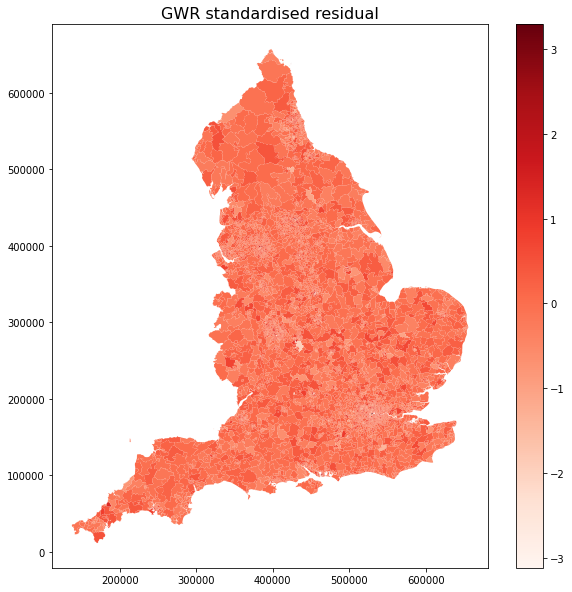

In [104]:
# visualise the residuals
# f,ax=plt.subplots(2,3,figsize=(15,6), subplot_kw=dict(aspect='equal'))
# # Flatten them
# ax = ax.flatten()

# (gdf_gwr_result
#  .sort_values('resid')
#  .plot('resid',
#        ax=ax,
#        legend=True,
#        vmin=np.min(gdf_gwr_result.resid),
#        vmax=np.max(gdf_gwr_result.resid),
#        cmap='Reds'))

# ax.set_xticklabels([])
# ax.set_yticklabels([])
# ax.set_xticks([])
# ax.set_yticks([])

# ax.set_title('residual', fontsize=16)
    
# f.tight_layout()
    
# plt.show()

f, ax = plt.subplots(1,1, figsize=(10,10))
ax.set_title('GWR standardised residual', fontsize=16)
# gwr_resid = results.resid_response
gdf_gwr_result.plot('resid',
       ax=ax,
       legend=True,
       vmin=np.min(gdf_gwr_result.resid),
       vmax=np.max(gdf_gwr_result.resid),
       cmap='Reds')

In [105]:
gdf_gwr_result.columns

Index(['OBJECTID', 'MSOA11CD', 'MSOA11NM', 'MSOA11NMW', 'BNG_E', 'BNG_N',
       'LONG', 'LAT', 'Shape__Are', 'Shape__Len', 'geometry', 'MSOA',
       'intercept', 'employ_score', 'edu_score', 'health_score', 'crime_score',
       'housing_score', 'livEnv_score', 'pct_hh_car', 'pct_Mixed', 'pct_Asian',
       'pct_black', 'pct_other', 'resid', 'localR2'],
      dtype='object')

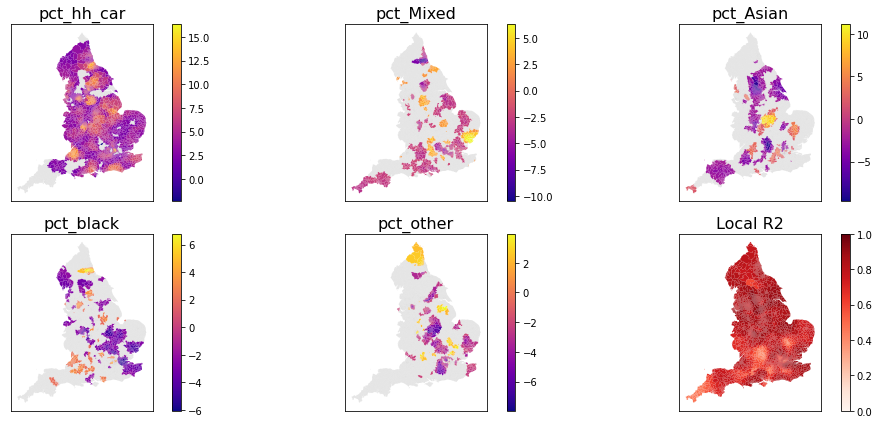

In [106]:
# Change the code. Not using df2 here
f,ax=plt.subplots(2,3,figsize=(15,6), subplot_kw=dict(aspect='equal'))
# Flatten them
ax = ax.flatten()
# Define the title of our plots
titles = ['pct_hh_car',
 'pct_Mixed',
 'pct_Asian',
 'pct_black',
 'pct_other']

# Here, we are creating loop for our parameter estimates 
for i,var in enumerate(titles):
    # We want to plot all the non-significant estimates in grey
    ct_temp = gdf_gwr_result.assign(toplot=gdf_gwr_result[var])
    (ct_temp.query('toplot==0')
     .sort_values('toplot')
     .plot(color='grey',ax=ax[i],alpha=.2))
    # and assign colours only to the significant estimates
    (ct_temp.query('toplot!=0')
     .sort_values('toplot')
     .plot('toplot',
           cmap='plasma',
           ax=ax[i],
           legend=True))
    
    ax[i].set_title(titles[i], fontsize=16)
    
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
 
# For the last one, local R2, we can just map all of them regarding the significance

(gdf_gwr_result
 .sort_values('localR2')
 .plot('localR2',
       ax=ax[-1],
       legend=True,
       vmin=0,
       vmax=1,
       cmap='Reds'))
    
ax[-1].set_xticklabels([])
ax[-1].set_yticklabels([])
ax[-1].set_xticks([])
ax[-1].set_yticks([])
    
ax[-1].set_title('Local R2', fontsize=16)
    
f.tight_layout()
    
plt.show()


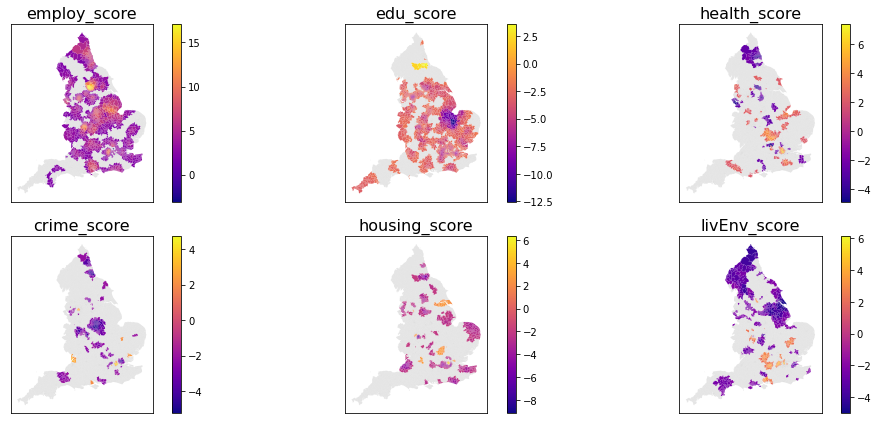

In [107]:
# create empty set of subplots with 2 rows and 3 columns
f,ax=plt.subplots(2,3,figsize=(15,6), subplot_kw=dict(aspect='equal'))
# Flatten them
ax = ax.flatten()
# Define the title of our plots and the variables to plot
titles = ['employ_score','edu_score', 'health_score', 'crime_score', 'housing_score', 'livEnv_score']

# Here, we are creating loop for our parameter estimates 
# grey means coef of 0
for i,var in enumerate(titles):
    # We want to plot all the non-significant estimates in grey
    ct_temp = gdf_gwr_result.assign(toplot=gdf_gwr_result[var])
    (ct_temp.query('toplot==0')
     .sort_values('toplot')
     .plot(color='grey',ax=ax[i],alpha=.2))
    # and assign colours only to the significant estimates
    (ct_temp.query('toplot!=0')
     .sort_values('toplot')
     .plot('toplot',
           cmap='plasma',
           ax=ax[i],
           legend=True))
    
    ax[i].set_title(titles[i], fontsize=16)
    
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
f.tight_layout()
    
plt.show()
